# Tweet Emotion Recognition : NLP using TensorFlow


# ALL IMPORTED FILES

In [6]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

sns.set(font_scale=1.3)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC




#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# About Dataset


In [8]:
# Read datasets
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

In [9]:
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [10]:
df_test.head()


,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [11]:
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


# Assessing

Train Dataset


In [12]:
df_train.Emotion.value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [13]:
df_train.Emotion.value_counts() / df_train.shape[0] *100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

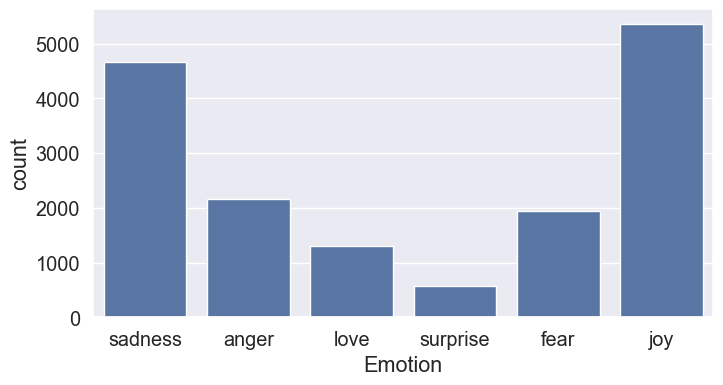

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

In [15]:
df_train.isnull()
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [16]:
df_train.duplicated().sum()


1

In [17]:
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [18]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [19]:
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]


,Text,Emotion
1625,i was intensely conscious of how much cash i h...,anger
7623,i was intensely conscious of how much cash i h...,sadness


In [20]:
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [21]:
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

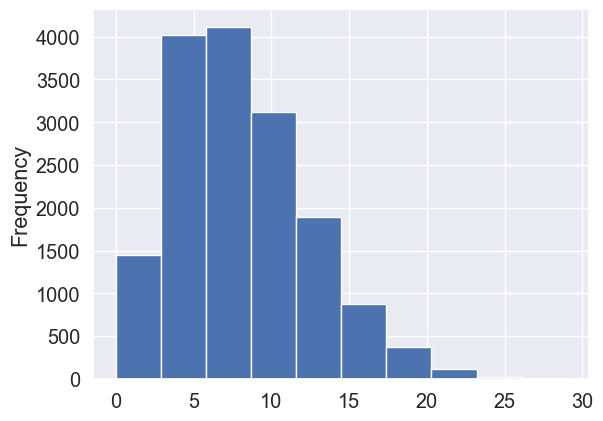

In [22]:
temp['stop_words'].plot(kind= 'hist')

 Test Dataset

In [23]:
df_test.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

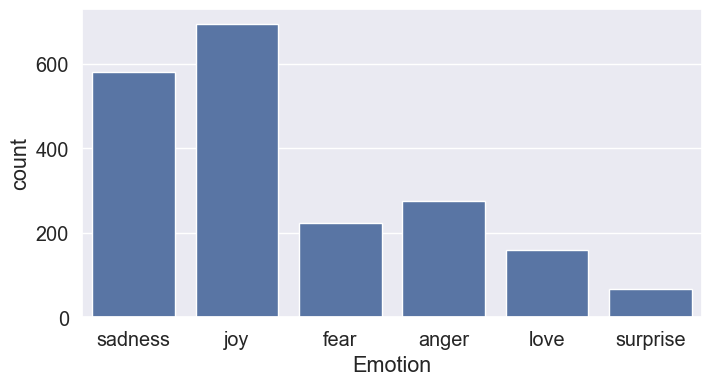

In [24]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [25]:
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [26]:
df_test.duplicated().sum()


0

In [27]:
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

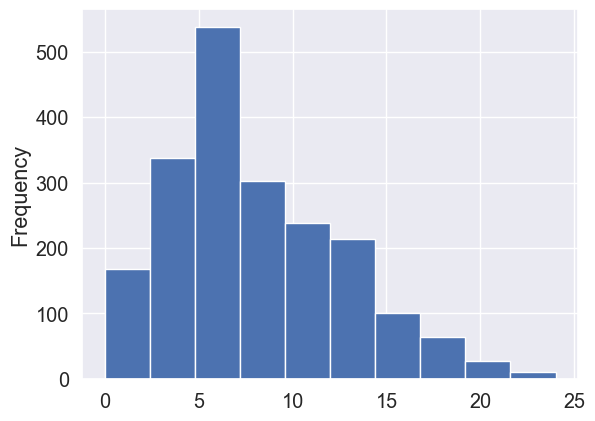

In [28]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

 Validation Dataset

In [29]:
df_val.Emotion.value_counts()


Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

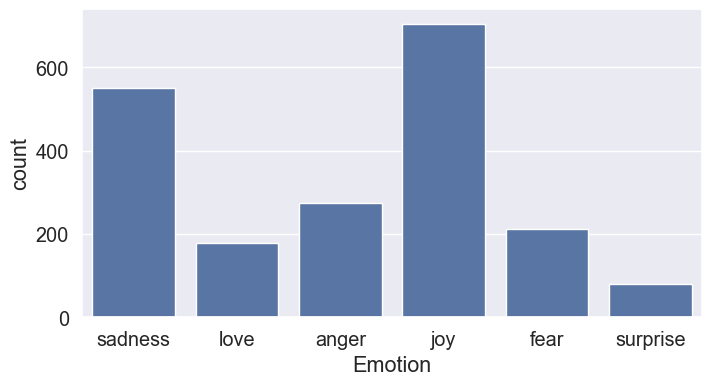

In [30]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [31]:
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [32]:
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [33]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']]

,Text,Emotion
300,i have had several new members tell me how com...,love
603,i have had several new members tell me how com...,joy


In [34]:
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [35]:
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]


stop_words
7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

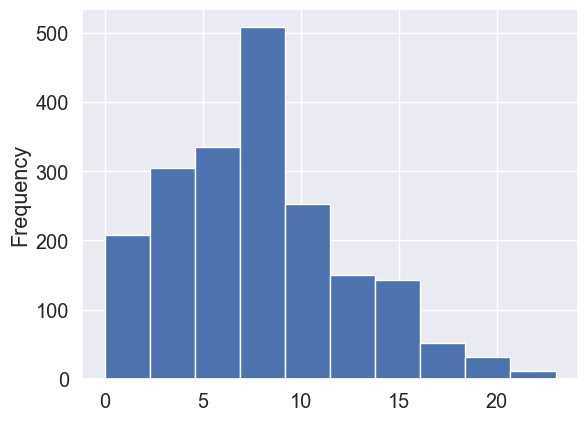

In [36]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

# data cleaning

In [37]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

In [38]:
def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

In [39]:
def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

In [40]:
def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

In [52]:
def Removing_punctuations(text):
    # Remove punctuations
    text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛', "")
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    text = " ".join(text.split())
    return text.strip()


<>:3: SyntaxWarning: invalid escape sequence '\]'
<>:3: SyntaxWarning: invalid escape sequence '\]'
C:\Users\shubh\AppData\Local\Temp\ipykernel_17680\819324494.py:3: SyntaxWarning: invalid escape sequence '\]'
  text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)


In [42]:
def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [43]:
def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

In [44]:
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

In [53]:
def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [56]:
normalized_sentence("My Name is Shubh. likes @music,  plays  cricket  2024 World cup")

'name shubh like music play cricket world cup'

In [57]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

# Modeling

In [58]:
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [59]:
def train_model(model, data, targets):
    
    
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    text_clf.fit(data, targets)
    return text_clf

In [60]:
def get_F1(trained_model,X,y):
    predicted=trained_model.predict(X)
    f1=f1_score(y,predicted, average=None)
    return f1

# Logistic Regression Model

In [61]:
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)
y_pred=log_reg.predict(['Happy'])
y_pred

array(['joy'], dtype=object)

In [62]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8685 



,F1 score
sadness,0.858223
anger,0.823810
love,0.893048
surprise,0.703704
fear,0.915683
joy,0.626263


# Using Decision Tree

In [63]:
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

y_pred=DT.predict(X_test)

DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.859 



,F1 score
sadness,0.873440
anger,0.798206
love,0.890671
surprise,0.737805
fear,0.900605
joy,0.617647


# Using Support Vector Machine Model

In [64]:
SVM = train_model(SVC(random_state = 0), X_train, y_train)

y_pred=SVM.predict(X_test)

SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.8675 



,F1 score
sadness,0.857685
anger,0.827907
love,0.893645
surprise,0.681648
fear,0.914821
joy,0.654206


# Using Random Forest

In [65]:
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

y_pred=RF.predict(X_test)

RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.8895 



,F1 score
sadness,0.903811
anger,0.868421
love,0.908199
surprise,0.738983
fear,0.933798
joy,0.634146


# Final Result Using these Algorithms

In [66]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), DT_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Random Forest,0.89
1,Logistic Regression,0.87
2,Support Vector Machine,0.87
3,Decision Tree,0.86
